`!pip list | egrep "torch|diffusers|transformers"`

```
came-pytorch                  0.1.3
clip-anytorch                 2.6.0
dctorch                       0.1.2
diffusers                     0.33.1
lion-pytorch                  0.1.2
open_clip_torch               2.26.1
sentence-transformers         2.3.1
torch                         2.4.0
torch-grammar                 0.3.3
torchdiffeq                   0.2.4
torchmetrics                  1.6.1
torchsde                      0.2.6
torchvision                   0.19.0
transformers                  4.51.3
transformers-stream-generator 0.0.5
```

# ImageNet Intro

In [ ]:
from datasets import load_dataset
from torchvision.utils import make_grid
from torchvision import transforms

In [ ]:
ds = load_dataset(
    "visual-layer/imagenet-1k-vl-enriched", 
    cache_dir="~/ssd-2TB/hf_cache",
    num_proc = 10,
)

In [ ]:
ds

In [ ]:
from PIL import Image
import math

def make_grid(images, rows, cols, height):
    # Check if we have enough images to fill the grid
    if len(images) > rows * cols:
        print(f"Warning: Only using the first {rows * cols} images out of {len(images)}")
        images = images[:rows * cols]
    
    # Resize all images to the specified height while maintaining aspect ratio
    resized_images = []
    for img in images:
        aspect_ratio = img.width / img.height
        new_width = int(height * aspect_ratio)
        resized_images.append(img.resize((new_width, height), Image.LANCZOS))
    
    # Calculate total width required for each row and the grid height
    row_widths = []
    grid_height = 0
    
    for row in range(rows):
        start_idx = row * cols
        end_idx = min(start_idx + cols, len(resized_images))
        if start_idx >= len(resized_images):
            break
            
        # Sum the widths of all images in this row
        row_width = sum(img.width for img in resized_images[start_idx:end_idx])
        row_widths.append(row_width)
        grid_height += height
    
    # Find the maximum row width to determine grid width
    max_row_width = max(row_widths) if row_widths else 0
    
    # Create a new blank image for the grid
    grid_image = Image.new('RGB', (max_row_width, grid_height), color='white')
    
    # Paste images into the grid with even spacing across each row
    img_index = 0
    y_offset = 0
    
    for row in range(rows):
        start_idx = row * cols
        end_idx = min(start_idx + cols, len(resized_images))
        if start_idx >= len(resized_images):
            break
            
        # Get images for this row
        row_images = resized_images[start_idx:end_idx]
        num_images = len(row_images)
        
        # Calculate total width of images in this row
        total_img_width = sum(img.width for img in row_images)
        
        # Calculate spacing between images (if more than one image in the row)
        if num_images > 1:
            spacing = (max_row_width - total_img_width) / (num_images - 1)
        else:
            # Center a single image in the row
            spacing = 0
            
        # Place images with calculated spacing
        x_offset = 0
        for i, img in enumerate(row_images):
            grid_image.paste(img, (int(x_offset), y_offset))
            x_offset += img.width + spacing
            
        y_offset += height
    
    return grid_image

In [ ]:
images = ds["train"][60:100]["image"]

In [ ]:
grid=make_grid([
    i for i in images
], rows=5, cols=5, height=256)
grid

# Latent dataset

In [ ]:
import torch
from tqdm import tqdm

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [ ]:
from diffusers import AutoencoderDC

model_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

dcae = AutoencoderDC.from_pretrained(
    model_repo, 
    subfolder="vae", 
    torch_dtype=dtype
).to(device)

In [ ]:
from utils import latent_to_PIL, PIL_to_latent

In [ ]:
import torchvision.transforms as T

def resize_max_dim(image, dim=256):
    return T.Resize(dim, antialias=True)(image)

def resize_closest_multiple(image, denom=32):
    w, h = image.size
    w = round(w / denom) * denom
    h = round(h / denom) * denom
    return image.resize((w, h))

In [ ]:
latent_imgs = []

for i in tqdm(range(40)):
    image = images[i]
    image = image.convert('RGB') if image.mode != "RGB" else image
    image = resize_max_dim(image)
    image = resize_closest_multiple(image)
    latent = PIL_to_latent(image, dcae)
    latent_imgs.append(latent_to_PIL(latent, dcae))

In [ ]:
grid=make_grid([
    i for i in latent_imgs
], rows=5, cols=5, height=256)
grid

In [ ]:
T.Resize(256, antialias=True)(images[7])

In [ ]:
latent_imgs[7]

In [ ]:
T.Resize(256, antialias=True)(images[10])

In [ ]:
latent_imgs[10]

# TRAIN

## Model definition

In [ ]:
import torch
from tqdm import tqdm

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [ ]:
from diffusers import SanaTransformer2DModel

# Load Sana 600M config
config = SanaTransformer2DModel.load_config(
    "Efficient-Large-Model/Sana_600M_1024px_diffusers", 
    subfolder="transformer"
)

# Reduce depth
config["num_layers"] = 12

# Reduce width
config["num_attention_heads"] = 12
config["attention_head_dim"] = 64
config["cross_attention_dim"] = 768
config["num_cross_attention_heads"] = 12
config["cross_attention_head_dim"] = 64

# Adapt to hidden size of SmolLM2
config["caption_channels"] = 960

transformer = SanaTransformer2DModel.from_config(config).to(dtype).to(device)

## Load text encoder and DCAE

In [ ]:
from transformers import AutoModel, AutoTokenizer
from diffusers import AutoencoderDC, SanaTransformer2DModel

te_repo = "HuggingFaceTB/SmolLM2-360M"
sana_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

# Load the text encoder and tokenizer
tokenizer = AutoTokenizer.from_pretrained(te_repo, torch_dtype=dtype)
# Pad token is not set by default, use eos
tokenizer.pad_token = tokenizer.eos_token
text_encoder = AutoModel.from_pretrained(te_repo, torch_dtype=dtype).to(device)

# Load Deep Compression AutoEncoder
dcae = AutoencoderDC.from_pretrained(sana_repo, subfolder="vae", torch_dtype=dtype).to(device)

## Load dataset

In [ ]:
from utils import load_IN1k256px_AR

# load g-ronimo/IN1k256-AR-buckets-bfl16latents_dc-ae-f32c32-sana-1.0
# Drop 10% of labels for CFG
dataloader_train, dataloader_eval = load_IN1k256px_AR(
  batch_size=256, label_dropout=0.1
)

In [ ]:
import torch.nn.functional as F
from utils import encode_prompt, add_random_noise

transformer.train()

optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0005)

step = 0 
epochs = 100

for e in range(epochs):
    for labels, latents in dataloader_train:
        step += 1
        epoch = step/len(dataloader_train)

        # Encode prompts
        prompts_emb, prompts_atnmask = encode_prompt(labels, max_length=50, tokenizer=tokenizer, text_encoder=text_encoder)

        # Scale latent and add random amount of noise
        latents = latents.to(dtype).to(device)
        latents *=  dcae.config["scaling_factor"]
        latents_noisy, timestep, noise = add_random_noise(latents)
        
        # Get a noise prediction out of the model
        noise_pred = transformer(
            hidden_states = latents_noisy.to(dtype), 
            encoder_hidden_states = prompts_emb, 
            encoder_attention_mask = prompts_atnmask,
            timestep = timestep, 
        ).sample

        optimizer.zero_grad()

        # Calculate gradients
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()    

        # Clip gradients
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)

        # Update weights
        optimizer.step()
    
        if step % 10 == 0:
            print(f"step {step} epoch {epoch:.2f} loss: {loss.item()}")


# Classifier Free Guidance (CFG) with Sana

In [14]:
import torch, random, requests
from tqdm import tqdm
from utils import generate, pil_concat, pil_add_text

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
from diffusers import AutoencoderDC
from transformers import Gemma2Model, GemmaTokenizerFast
from diffusers import SanaTransformer2DModel

model_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

tokenizer = GemmaTokenizerFast.from_pretrained(
    model_repo, subfolder="tokenizer"
)
text_encoder = Gemma2Model.from_pretrained(
    model_repo, subfolder="text_encoder", torch_dtype=dtype
).to(device)
transformer = SanaTransformer2DModel.from_pretrained(
    model_repo, subfolder="transformer", torch_dtype=dtype
).to(device)
dcae = AutoencoderDC.from_pretrained(
    model_repo, subfolder="vae", torch_dtype=dtype
).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

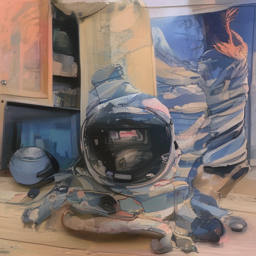

In [9]:
generate(
    "", 
    transformer, tokenizer, text_encoder, dcae,
    seed=32, 
    num_steps=20, 
    latent_dim = [1, 32, 32, 32], 
    guidance_scale=1,
    add_special_tokens = True,
).resize((256, 256))

100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]


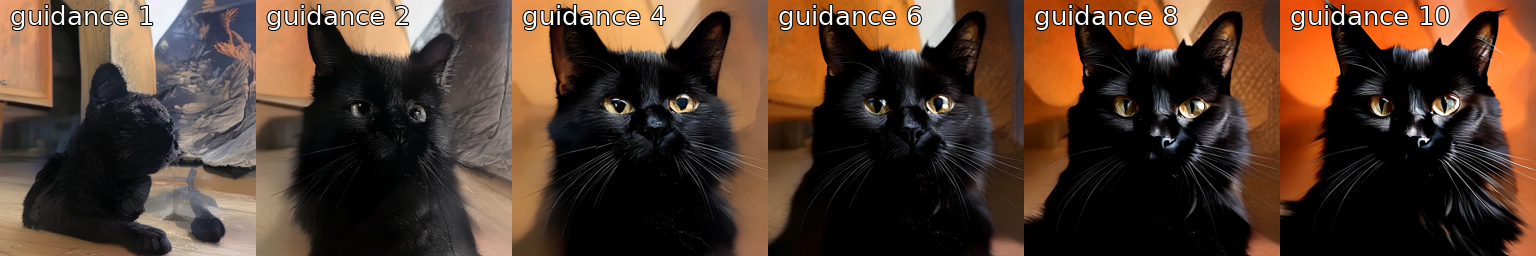

In [24]:
prompt = "A beautiful black cat"

images = [
    pil_add_text(
        generate(
            prompt, 
            transformer, tokenizer, text_encoder, dcae,
            seed=32, 
            num_steps=20, 
            latent_dim = [1, 32, 32, 32], 
            guidance_scale=guidance_scale,
            add_special_tokens = True,
        ).resize((256, 256)),
        text = f"guidance {guidance_scale}",
        position = (10,0),        
    )
    for guidance_scale in tqdm([1, 2, 4, 6, 8, 10])
]
pil_concat(images)

# Hana Inference

In [7]:
import torch 
from utils import generate
from tqdm import tqdm

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [2]:
from diffusers import AutoencoderDC
from transformers import AutoModel, AutoTokenizer
from diffusers import AutoencoderDC, SanaTransformer2DModel

te_repo = "HuggingFaceTB/SmolLM2-360M"
sana_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

# Load the text encoder and tokenizer
tokenizer = AutoTokenizer.from_pretrained(te_repo, torch_dtype=dtype)
# Pad token is not set by default, use eos
tokenizer.pad_token = tokenizer.eos_token
text_encoder = AutoModel.from_pretrained(te_repo, torch_dtype=dtype).to(device)

# Load Deep Compression AutoEncoder
dcae = AutoencoderDC.from_pretrained(sana_repo, subfolder="vae", torch_dtype=dtype).to(device)

# Load the DiT trained on ImageNet
transformer = SanaTransformer2DModel.from_pretrained(
    "g-ronimo/HanaDitB_0530_beta-8", 
    variant="epoch99", 
    torch_dtype=dtype
).to(device)

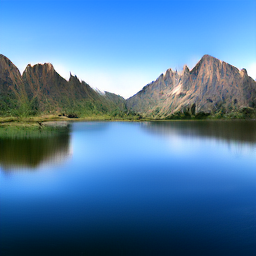

In [3]:
from utils import generate

generate(
    "a mountain and its reflection in a lake",
    transformer, tokenizer, text_encoder, dcae,
    seed=42,
    num_steps=20,
    guidance_scale=7
)

In [6]:
with open('ImageNet_eval_prompts.txt', 'r') as file:
    # Read all lines into a list
    lines = file.readlines()
prompts = [line.strip() for line in lines]
prompts[:5]

['a mountain and its reflection in a lake',
 'a teapot',
 'a cat',
 'a violin',
 'a plant with small flowers with purple petals']

In [12]:
from utils import generate, make_grid

images = [
    generate(
        prompt,
        transformer, tokenizer, text_encoder, dcae,
        seed=42,
        num_steps=20,
        guidance_scale=7
    )
    for prompt in tqdm(prompts)
]

100%|███████████████████████████████████████████| 40/40 [00:13<00:00,  2.88it/s]


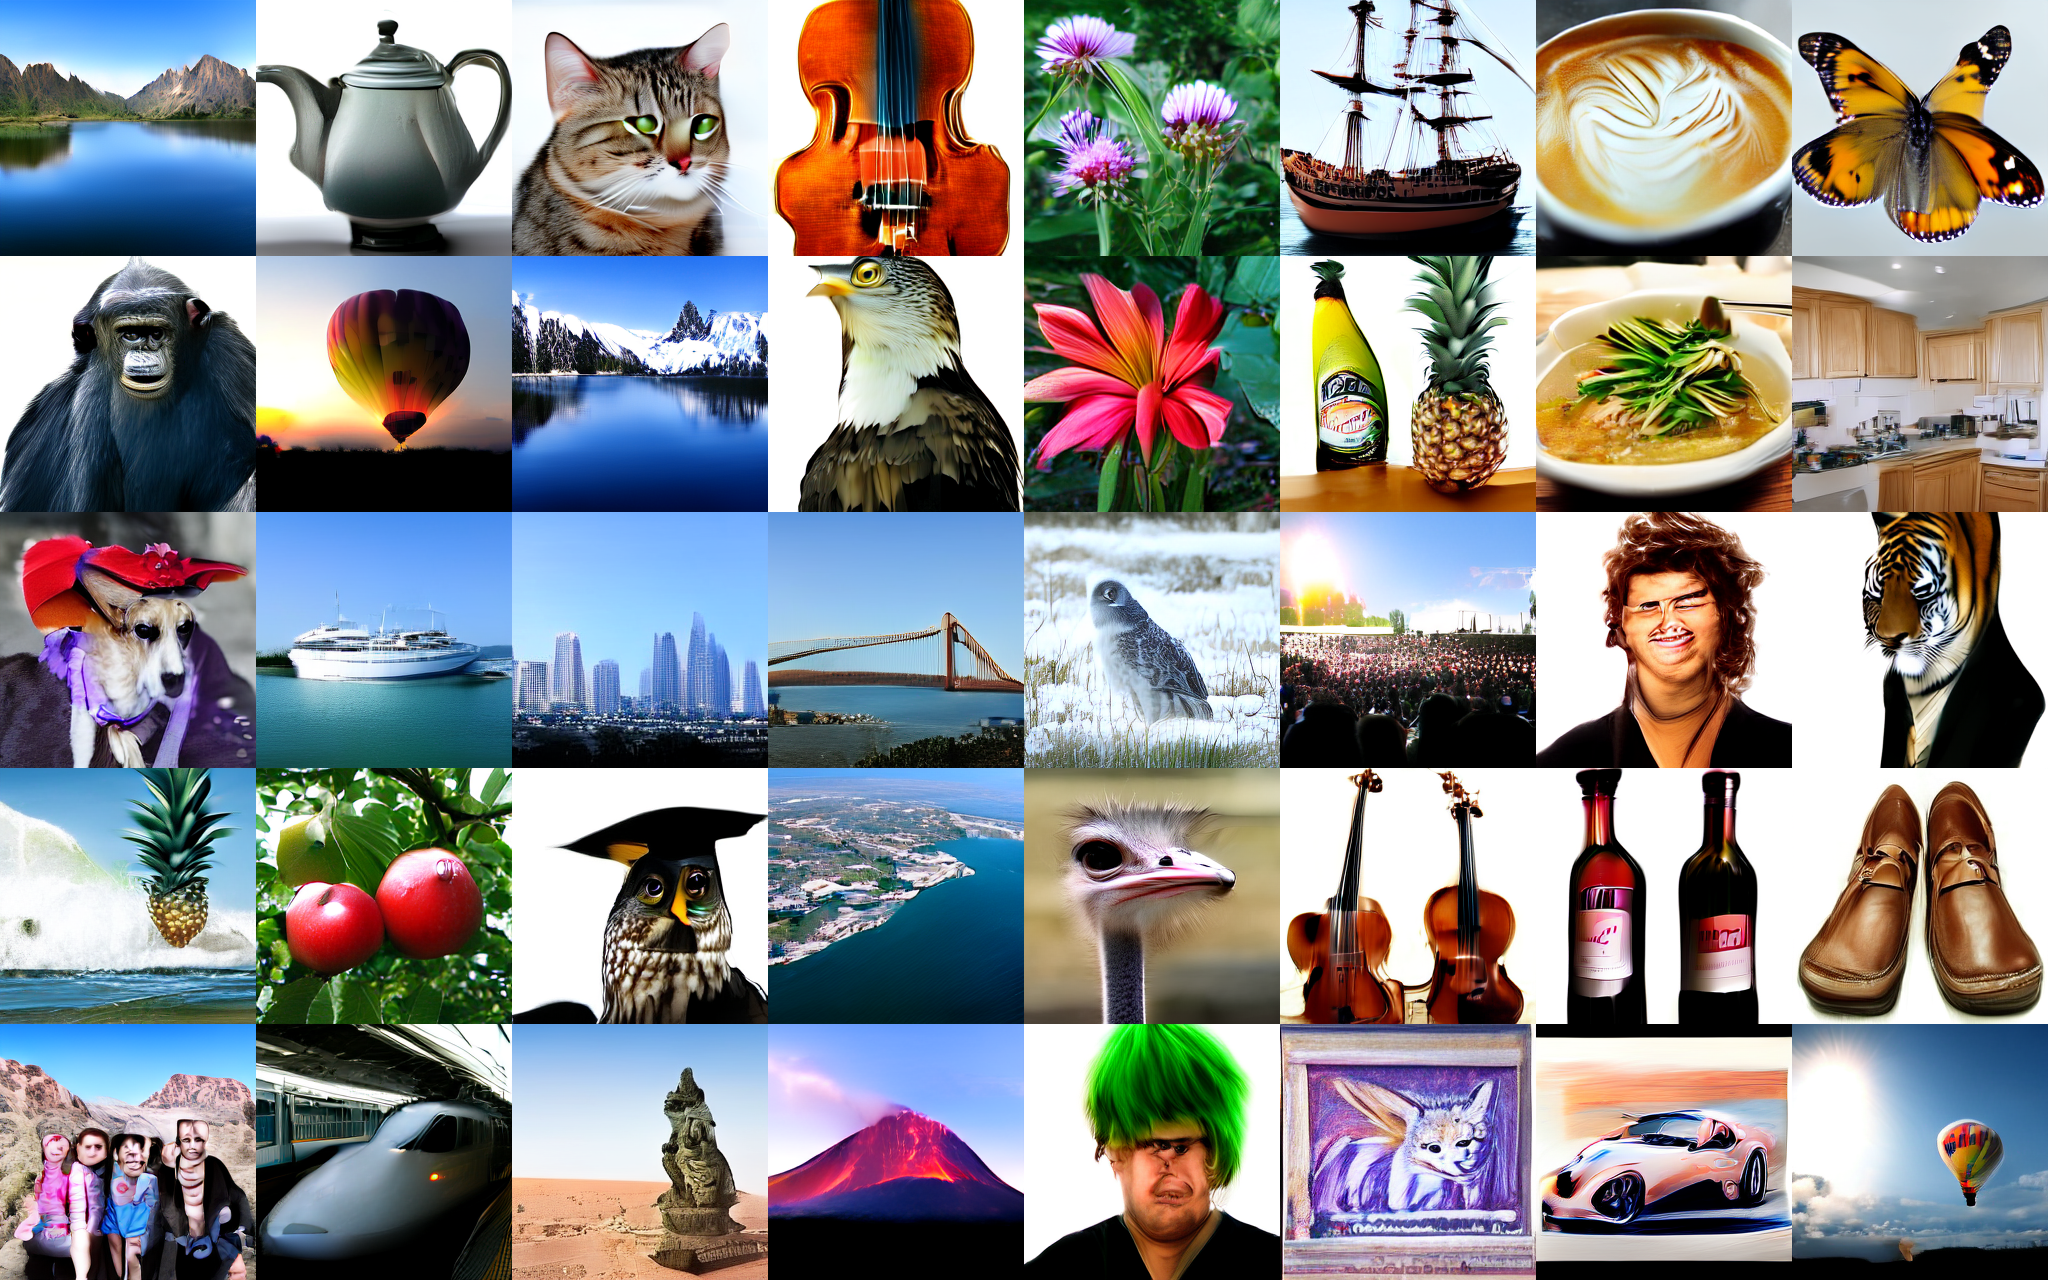

In [14]:
make_grid(images, cols=8, rows=5)